<h1 style="color:rgb(0,120,170)">Neural Networks and Deep Learning</h1>
<h2 style="color:rgb(0,120,170)">PyTorch and TensorFlow Comparison</h2>

[Source](https://towardsdatascience.com/pytorch-vs-tensorflow-in-code-ada936fd5406)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
print(tf.__version__)

2.3.1


Both TensorFlow and PyTorch are machine learning frameworks specifically designed for developing deep learning algorithms with access to the computational power needed to process lots of data (e.g. parallel computing, training on GPUs, etc).

TensorFlow, which comes out of Google, was released in 2015 under the Apache 2.0 license. In Oktober 2019, TensorFlow 2.0 was released, which is said to be a huge improvement. It’s typically used in Python. PyTorch, on the other hand, comes out of Facebook and was released in 2016 under a similarly permissive open source license. As its name suggests, it’s also a Python library.
Model Definition

Back to the main reason for this blog post. The plan is to implement a simple neural network architecture in both TensorFlow and PyTorch to see some of the similarities and differences.

The neural network model consists of three layers: Embedding Layer → Global Average Pooling Layer → Dense Layer.

#### Dataset and Preprocessing

The dataset used here consists of 1600,000 tweets and their sentiment (0=negative, 1=positive). First, loading the data from a CSV file and displaying some rows of the data frame to get an idea of the data.

In [3]:
## https://www.kaggle.com/kazanova/sentiment140
#df = pd.read_csv('./training.1600000.processed.noemoticon.csv', engine='python', usecols=[0,5], encoding='utf-8', names=['sentiments', 'tweets'])
#df.sentiments = df.sentiments.map({0:0, 4:1})
#df.to_csv('../Data/tweets.csv.gz', encoding='utf-8', compression="gzip", index=False, header=True)

In [4]:
data_path = "../Data/tweets.csv.gz"
data = pd.read_csv(data_path, encoding='utf-8')
data.head()

,sentiments,tweets
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   sentiments  1600000 non-null  int64 
 1   tweets      1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


# Dataset and Preprocessing

To vectorize the tweets, I used Keras’ tokenizer here but there’re countless others that can do the same or even more.  

In [6]:
# instantiate and fit tokenizer
tokenizer = Tokenizer(num_words=20000, oov_token='<00v>')
tokenizer.fit_on_texts(data.tweets)

# transform tweets into sequences of integers
sequences = tokenizer.texts_to_sequences(data.tweets)

# pad sequences so that they have uniform lenth
padded = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=42)
assert(padded.shape==(1600000,42))

In [7]:
seq = padded
labels = np.array(data.sentiments)

Here’s what happens in the code snippet above. We assign an integer to each of the 20,000 most common words of the tweets and then turn the tweets into sequences of integers. We pad shorter ones with zeros and cut off longer ones, forcing a sequence length of 42. Finally, we should have a matrix of dimension 40,000 x 42 (tweets x sequence length).

# TensorFlow 2.0

Creating TensorFlow models is typically done using Keras. Keras is built on top of TensorFlow and allows for easy and fast prototyping because it has many layers built-in — it would be tedious or even prohibitive to code them from scratch each time.

There are three ways to build a neural network model in Keras.

## 1. Subclassing API

You can create your own fully-customizable models by subclassing the tf.keras.Model class and implementing the forward pass in the call method. Put differently, layers are defined in the __init__() method and the logic of the forward pass in the call method.

In [8]:
class Subclass_Model(tf.keras.Model):
    
    def __init__(self, embedding_dim=25):
        super(Subclass_Model, self).__init__()
        self.embedding_layer = tf.keras.layers.Embedding(input_dim=20000,
                                                         output_dim=50,
                                                         input_length=42)
        self.pool1D_layer = tf.keras.layers.GlobalAveragePooling1D()
        self.fc_layer =  tf.keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, inputs):
        x = self.embedding_layer(inputs)
        x = self.pool1D_layer(x)
        return self.fc_layer(x)
    
model = Subclass_Model()

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

The benefit of using such an object-oriented approach is that you can reuse layers multiple times within the call method or define a more complex forward pass. But nothing like that is happening in this example here, it’s just a linear stack of layers.

## 2. Functional API

In the functional API, given some input tensor(s) and output tensor(s), you can also instantiate a Model. It’s a user-friendly way to build a neural network and Keras even recommends it over model subclassing. With this approach, you essentially define a layer and immediately pass it the input of the previous layer. So it requires slightly less coding with the same result.

In [9]:
inputs = tf.keras.layers.Input(shape=(42,))
x = tf.keras.layers.Embedding(input_dim=20000,
                              output_dim=50,
                              input_length=42)(inputs)

x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 42)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 42, 50)            1000000   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 1,000,051
Trainable params: 1,000,051
Non-trainable params: 0
_________________________________________________________________


## 3. Sequential API

The sequential API is the most compact way to define a model and sufficient for certain (simple) neural networks, typically consisting of just a few common layers — kind of a shortcut to a trainable model. It’s definitely convenient and works well but is too inflexible if you wish to implement more sophisticated ideas.

Training a Neural Network in Keras

Before you can train a Keras model, it must be compiled by running the model.compile() function, which is also where you specify the loss function and optimizer.

Regardless of how you build a Keras model, there are two functions I’d like to show you. First, calling model.summary() prints a compact summary of the model and the number of parameters, which is super useful.

In [10]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(input_dim=20000,
                                    output_dim=50,
                                    input_length=42))

model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 42, 50)            1000000   
_________________________________________________________________
global_average_pooling1d_2 ( (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 1,000,051
Trainable params: 1,000,051
Non-trainable params: 0
_________________________________________________________________


## Training a Keras model

Keras models have a convenient fit function for training a model (just like Scikit-Learn), which also takes care of batch processing and even evaluates the model on the run (if you tell it to do so).  
Note: It’s okay to pass Numpy arrays as inputs to the fit function even though TensorFlow (PyTorch too for that matter) operates on tensors only, which is a similar data structure but optimized for matrix computations. Keras takes care of transforming the arrays under the hood.

In [11]:
# train the model
model.fit(x=seq,
          y=labels,
          batch_size=32,
          epochs=3,
          verbose=2,
          validation_split=0.2)

Epoch 1/3
40000/40000 - 194s - loss: 0.4465 - accuracy: 0.8026 - val_loss: 0.6137 - val_accuracy: 0.7357
Epoch 2/3
40000/40000 - 187s - loss: 0.4285 - accuracy: 0.8146 - val_loss: 0.6724 - val_accuracy: 0.6910
Epoch 3/3
40000/40000 - 196s - loss: 0.4256 - accuracy: 0.8163 - val_loss: 0.6978 - val_accuracy: 0.6776


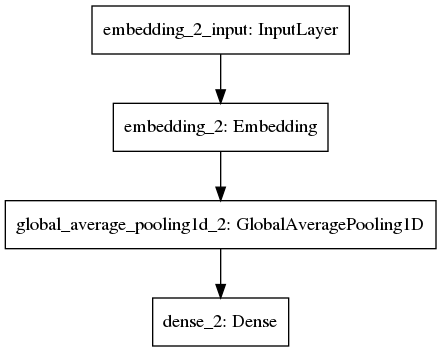

In [12]:
# Second, by calling tf.keras.utils.plot_model() you get a graphical summary of the model. 
tf.keras.utils.plot_model(model, to_file='../images/model.png', show_shapes=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

# PyTorch

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

Note: In oder to process the data in batches, a dataloader must be created. The dataloader returns one batch at a time in a dictionary format.

In [14]:
class MyDataset(Dataset):
    def __init__(self, tweets, sentiments):
        self.tweets = tweets
        self.sentiments = sentiments
        
    def __getitem__(self, index):
        sample = {"tweets":torch.LongTensor(self.tweets[index,:]),
                  "sentiments":self.sentiments[index]}
        return sample
        
    def __len__(self):
        return self.tweets.shape[0]
    
    
tweets_dataset = MyDataset(seq, labels.astype(float))
dataloader = DataLoader(tweets_dataset,
                        batch_size=32,
                        shuffle=True)

There are two ways to build a neural network model in PyTorch.

## 1. Subclassing

Similar to TensorFlow, in PyTorch you subclass the nn.Model module and define your layers in the __init__() method.  
The only difference is that you create the forward pass in a method named forward instead of call.

In [15]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=20000,
                                            embedding_dim=50)
        self.pooling_layer = nn.AvgPool1d(kernel_size=50)
        self.fc_layer = nn.Linear(in_features=42, 
                                  out_features=1)
        
    
    def forward(self, inputs):
        x = self.embedding_layer(inputs)
        x = self.pooling_layer(x).view(32, 42)
        return torch.sigmoid(self.fc_layer(x))
    
model = Model()

Note: Difference to the Keras model: There’s only an average-pooling layer in PyTorch so it needs to have the right kernel size in order the make it global average-pooling.

## 2. Sequential

PyTorch also offers a Sequential module that looks almost equivalent to TensorFlow’s.

In [16]:
model = nn.Sequential(nn.Embedding(num_embeddings=20000, embedding_dim=50),
                      nn.AvgPool1d(kernel_size=50),
                      nn.Flatten(start_dim=1),
                      nn.Linear(in_features=42, out_features=1),
                      nn.Sigmoid()
                     )

Note: I found that many layers do not work with PyTorch’s nn.Sequential such as many recurrent layers (RNNs, LSTMS, etc.).  In fact, PyTorch didn’t really want to implement the sequential module at all because it wants developers to use subclassing.

## Training a PyTorch Model

There’s no pre-made fit function for PyTorch models, so the training loop needs to be implemented from scratch. Here’s what a typical training loop in PyTorch looks like.

In [ ]:
# PyTorch training loop

#define the loss fn and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# empty list to track batch losses
batch_losses = []

#train the neural network for 5 epochs
for epoch in range(1):

    #reset iterator
    dataiter = iter(dataloader)
    
    #iterate over dataset
    for batch in dataiter:
                
        #reset gradients
        optimizer.zero_grad()
        
        #forward propagation through the network
        out = model(batch["tweets"])
        
        #print(out.shape, batch["sentiments"].shape)
        #calculate the loss
        #print(out.type())
        #print(batch["sentiments"].type())
        loss = criterion(out, batch["sentiments"].type(torch.FloatTensor))
        
        #track batch loss
        batch_losses.append(loss.item())
        
        #backpropagation
        loss.backward()
        
        #update the parameters
        optimizer.step()

/home/rsouza/Documents/envs/python_env/lib/python3.6/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Short description of the training loop: For each batch, we calculate the loss and then call loss.backward() to backpropagate the gradient through the layers. In addition, we call optimizer.step() to tell the optimizer to update the parameters. For a more detailed description of how to train a PyTorch model see [here](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html).